In [178]:
from support_functions import log_progress, clean_drugbank, query_chembl
import pandas as pd
import numpy as np
import itertools
from cmapPy.pandasGEXpress import parse
import requests
from scipy.stats import kendalltau
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)

In [226]:
# Visualization Parameters
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

___
# Exploratory analysis of LINCS gene expression data

Data downloaded from:
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92742

LINCS data User Guide: 
https://docs.google.com/document/d/1q2gciWRhVCAAnlvF2iRLuJ7whrGP6QjpsCMq1yWz7dU/

Here we'll just take an initial look at the gene expression data from the drug treatment and gene knockdown experiments in the LINCS library. 

___
## Import LINCS metadata

In [21]:
# Phase 1 metadata:
# cell line information
cell_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_cell_info.txt', sep='\t', header=0)
# primary gene symbols and IDs
gene_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_gene_info.txt', sep='\t', header=0)
# Metadata describing each perturbagen used in experiments (pert_id)
pert_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_pert_info.txt', sep='\t', header=0)
# Metadata for signatures of aggregated replicates (level 5 data)
sig_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_sig_info.txt', sep='\t', header=0, dtype={'pert_dose': float})
# Calculated / derived / inferred metrics and annotations associated with each signature in the Level 5 matrix
sig_metrics_1 = pd.read_csv('data/GSE92742_Broad_LINCS_sig_metrics.txt', sep='\t', header=0)

# Phase 2 metadata:
pert_info_2 = pd.read_csv('data/GSE70138_Broad_LINCS_pert_info.txt', sep='\t', header=0)
sig_info_2 = pd.read_csv('data/GSE70138_Broad_LINCS_sig_info_2017-03-06.txt', sep='\t', header=0, dtype={'pert_dose': float})
sig_metrics_2 = pd.read_csv('data/GSE70138_Broad_LINCS_sig_metrics_2017-03-06.txt', sep='\t', header=0)

# Combine Phase 1 & 2 data:
pert_info = pd.concat([pert_info_1, pert_info_2], ignore_index=True)
sig_info = pd.concat([sig_info_1, sig_info_2], ignore_index=True)
sig_metrics = pd.concat([sig_metrics_1, sig_metrics_2], ignore_index=True)

## LINCS perturbation types

What types of gene expression perturbation experiments are most common in the LINCS libray? From the plot below we see that the most common perturbations by far are small molecule compounds (trt_cp) and gene knockdowns (trt_sh). That's good for us, since these are the gene expression profiles we'll be using to predict drug-target interactions.

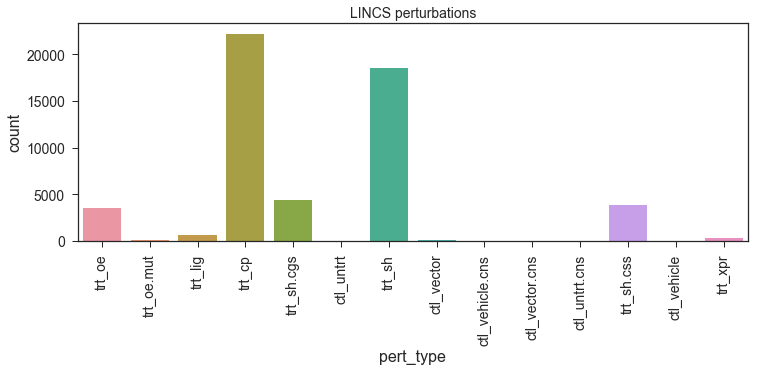

In [66]:
plt.figure(figsize=(12, 4))
sns.countplot(x="pert_type", data=pert_info)
plt.title("LINCS perturbations")
plt.xticks(rotation="vertical")
plt.show()

___
## Redundancy and data quality

We can see from the plots below that many compound and knockdown experiments have been performed multiple times. This is partially due to them being performed in different cell lines, but there is also redundancy within individual cell lines. To construct our gene expression correlation features, we will need to select one **representative** gene expression signature for each compound / knockdown in each cell line.

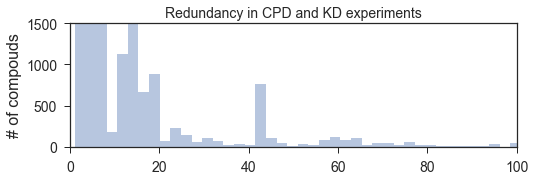

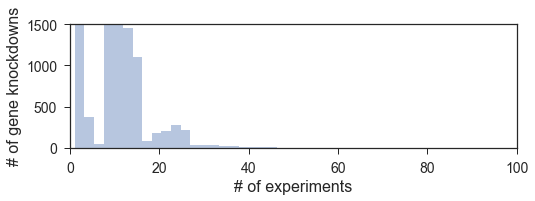

In [166]:
plt.figure(figsize=(8,5))
plt.subplot(211)
sns.distplot(sig_info[sig_info.pert_type == 'trt_cp'].pert_id.value_counts(), kde=False, bins=1000)
plt.xlim(0,100)
plt.ylim(0,1500)
plt.xlabel('')
plt.title('Redundancy in CPD and KD experiments')
plt.ylabel('# of compouds')
plt.show()

plt.figure(figsize=(8,5))
plt.subplot(212)
sns.distplot(sig_info[sig_info.pert_type == 'trt_sh'].pert_id.value_counts(), kde=False, bins=100)
plt.xlim(0,100)
plt.ylim(0,1500)
plt.xlabel('# of experiments')
plt.ylabel('# of gene knockdowns')
plt.show()

The plot below shows that most experiments are performed in only a subset of the posible cell lines in LINCS. Many cell lines have very little data.

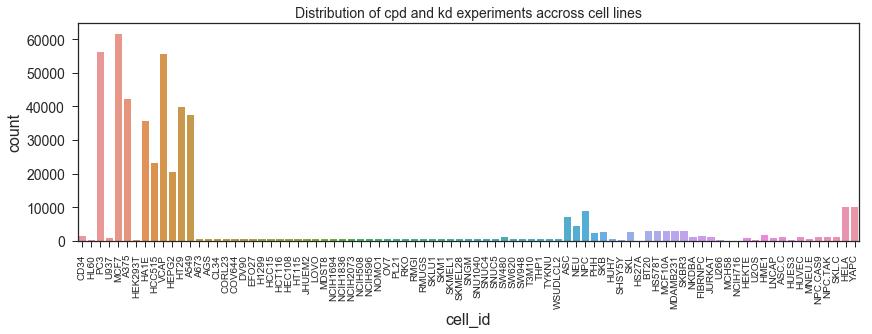

In [175]:
plt.figure(figsize=(14, 4))
sns.countplot(x="cell_id", 
              data=sig_info[(sig_info.pert_type == 'trt_sh') | 
                            (sig_info.pert_type == 'trt_cp')])
plt.title("Distribution of cpd and kd experiments accross cell lines")
plt.xticks(rotation="vertical", fontsize=10)
plt.show()

Data quality is not consistent accross repeat experiments of the same compound / knockdown in the same cell line. There are several measures of data quality that we are interested in, and which we can use to select **representative** signatures. Some of these are listed below and descibed in further detail in the LINCS data User Guide linked above.

- **pct_self_rank_q25**:  Self connectivity of replicates expressed as a percentage of total instances in a replicate set.
- **distil_cc_q75**:  75th quantile of pairwise spearman correlations in landmark space of replicate level 4 profiles.
- **tas**: Transcriptional activity score, a measure of the L1000 transcriptional response elicited by a perturbagen. TAS is computed as the geometric mean of the signature strength and the 75th quantile of pairwise replicate correlations for a given signature

The plots below show the joint and marginal distributions of these metrics for LINCS drug treatment and gene knockdown experiments

In [ ]:
# get all relevant signature quality info into one dataframe
all_sig_info = pd.concat([sig_info.pert_type, sig_metrics[['distil_cc_q75', 'pct_self_rank_q25', 'tas']]], axis=1)

# remove samples with missing or spurious data
sig_quality_info = all_sig_info[(all_sig_info.distil_cc_q75 > -1)
                                & (all_sig_info.pct_self_rank_q25 > -1)]

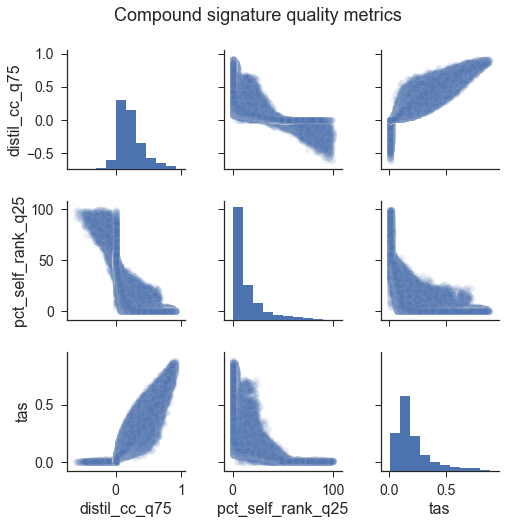

In [145]:
# compound treatment experiments
cpd_sig_quality_info = sig_quality_info[sig_quality_info.pert_type == 'trt_cp']
g = sns.pairplot(cpd_sig_quality_info,  plot_kws={'alpha': 0.1})
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Compound signature quality metrics')
plt.show()

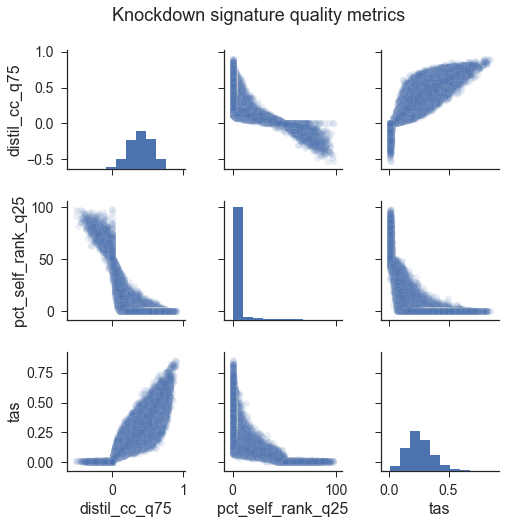

In [158]:
# knockdown treatment experiments
kd_sig_quality_info = sig_quality_info[sig_quality_info.pert_type == 'trt_sh']
g = sns.pairplot(kd_sig_quality_info,  plot_kws={'alpha': 0.1})
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Knockdown signature quality metrics')
plt.show()

___

We can use the above data quality measures to select representative signatures when multiple are available for a given perturbagen in a given cell line. We follow the selction criteria outlined in the user guide, which defines **gold** signatures as follows:

*A heuristic for assessing whether a signature is reproducible and distinct. Requirements include: distil_cc_q75 >= 0.2 and pct_self_rank_q25 <= 0.05.*

If multiple **gold** signatures are available for a compound or knockdown in a given cell line, we will select as representative the gold signature with the highest **tas**.

In [159]:
gold_sigs = all_sig_info[(all_sig_info['distil_cc_q75'] >= 0.2) 
                         & (all_sig_info['pct_self_rank_q25'] <= 0.05)
                        ].reset_index(drop=True)
gold_sigs.to_csv('checkpoint_files/gold_sigs.csv')

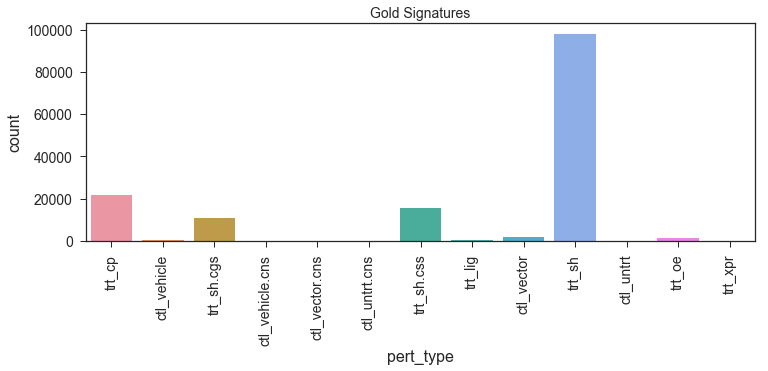

In [161]:
plt.figure(figsize=(12, 4))
sns.countplot(x="pert_type", data=gold_sigs)
plt.title("Gold Signatures")
plt.xticks(rotation="vertical")
plt.show()

___
# Drugs with known targets

We need known (True) drug-target interactions to train our classifier. How many LINCS compounds are drugs or chemical probes with known protein targets? To answer this question, we can use the DrugBank (https://www.drugbank.ca/) and ChEMBL (https://www.ebi.ac.uk/chembl/) databases. 

For clarity and organization, we deal with mining these databases in a separate notebook called: `known_target_mining.ipynb`. Here, we'll just briefly summarize the results:

In [180]:
# Load targets extracted from Drugbank and Chembl
LINCS_target_dict = pickle.load(open('checkpoint_files/LINCS_target_dict.sav', 'rb'))

In [224]:
# Find drugs with known targets and which of those targets have been knocked down
all_LINCS_cpd_ids = pert_info[pert_info.pert_type == 'trt_cp'].pert_id.unique().astype(str)
all_LINCS_kd_genes = set(pert_info[pert_info.pert_type == 'trt_sh'].pert_iname.unique().astype(str))
all_targets = [ LINCS_target_dict[cpd] if cpd in LINCS_target_dict.keys() else set() for cpd in all_LINCS_cpd_ids ]
all_targets_bool = [ len(s) > 0 for s in all_targets ]
LINCS_targets = [ s.intersection(all_LINCS_kd_genes) for s in all_targets ]
LINCS_targets_bool = [ len(s) > 0 for s in LINCS_targets ]
target_class = []
for i, label in enumerate(LINCS_targets_bool):
    if label: target_class.append('Known target - \ntarget KD in LINCS')
    elif all_targets_bool[i]: target_class.append('Known target - \ntarget KD not in LINCS')
    else: target_class.append('No known target')
target_df = pd.DataFrame({'pert_id':all_LINCS_cpd_ids, 'target':target_class})

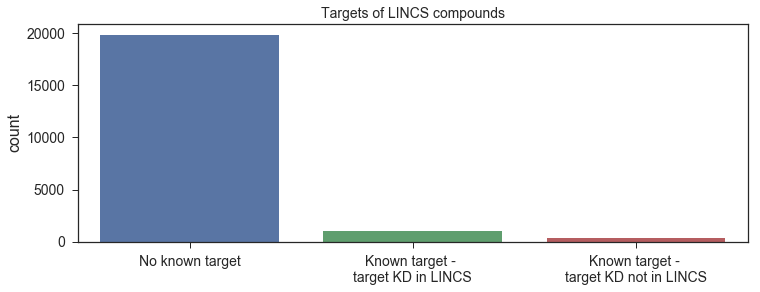

In [228]:
plt.figure(figsize=(12,4))
sns.countplot(x="target", data=target_df)
plt.title('Targets of LINCS compounds')
plt.xticks(fontsize=14)
plt.xlabel('')
plt.show()

As we can see in the plot above, most compounds tested in LINCS have no known targets. Of the compounds with known targets, the majority have targets that have been knocked down in LINCS experiments. This is good because we need both the compound signature and the target knockdown signature in order to predict whether an interaction is taking place.

## Looking up DrugBank targets of gold LINCS cpds

In [ ]:
pert_ids = []
pert_inames = []
inchi_keys = []
drugbank_targets = []

for index, row in gold_cpd_sigs.iterrows():
    inchi = row["inchi_key"]
    
    # ignore duplicates
    if inchi not in inchi_keys:
    
        if inchi in drugbank_target_dict.keys(): 
            pert_id = row["pert_id"]
            pert_iname = row["pert_iname"]
            targets = drugbank_target_dict[inchi]

            for target in targets:
                pert_ids.append(pert_id)
                pert_inames.append(pert_iname)
                inchi_keys.append(inchi)
                drugbank_targets.append(target)

gold_cpds_db_targets = pd.DataFrame({'pert_id': pd.Series(pert_ids), 
                                        'pert_iname': pd.Series(pert_inames), 
                                        'Drugbank_target': pd.Series(drugbank_targets),
                                        'inchi_key' : pd.Series(inchi_keys)
                                       })

#### 686 unique LINCS cpds with gold signatures have known targets in DrugBank. 
These correspond to 3239 drug-target pairs. Some cpds have many targets.

In [ ]:
num_target_list = pd.DataFrame({'num_targets': pd.Series(gold_cpds_db_targets['pert_id'].value_counts())})
f, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="num_targets", data=num_target_list)
plt.ylabel("# of gold cpds")
plt.xlabel("# of targets")
plt.show()

## Lookup ChEMBL targets using REST API

In [ ]:
seen_cpds = []
pert_ids = []
pert_inames = []
inchi_keys = []
chembl_targets = []

for index, row in log_progress(gold_cpd_sigs.iterrows(), every=1):
    pert_id = row['pert_id']
    
    # ignore duplicates
    if pert_id not in seen_cpds:
        seen_cpds.append(pert_id)
        pert_iname = row['pert_iname']
        inchi = row['inchi_key']

        # search CHEMBL using the inchi_key to find corresponding CHEMBL_IDs
        human_target_genes = query_chembl(inchi)

        if len(human_target_genes) > 0:
            for target in human_target_genes:
                pert_ids.append(pert_id)
                pert_inames.append(pert_iname)
                inchi_keys.append(inchi)
                chembl_targets.append(target)

gold_cpds_chembl_targets = pd.DataFrame({'pert_id': pd.Series(pert_ids),
                                         'pert_iname': pd.Series(pert_inames),
                                         'chembl_target': pd.Series(chembl_targets),
                                         'inchi_key' : pd.Series(inchi_keys)
                                        })

#### 434 unique LINCS cpds with gold signatures have known targets in ChEMBL. 
These correspond to 3697 drug-target pairs. Some cpds have many targets.

In [ ]:
num_target_list = pd.DataFrame({'num_targets': pd.Series(gold_cpds_chembl_targets['pert_id'].value_counts())})
f, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="num_targets", data=num_target_list)
plt.ylabel("# of gold cpds")
plt.xlabel("# of targets")
plt.show()

___
## Combining DrugBank and ChEMBL targets

<br> If DrugBank and ChEMBL had no overlap, we would expect their union to have 1120 unique gold cpds with 6936 drug-target pairs. Instead we find a total of **862 unique gold cpds with 6195 target interactions.** So there is some overlap but the two databases are surprisingly disjoint.

In [ ]:
gold_cpds_targets = pd.concat([gold_cpds_db_targets.rename(index=str, columns={"Drugbank_target": 'target'}),
                               gold_cpds_chembl_targets.rename(index=str, columns={"chembl_target": 'target'}), 
                              ], ignore_index=True).drop_duplicates().reset_index(drop=True)

# Save all the target info to files to save time in the future.
gold_cpds_db_targets.to_csv('checkpoint_files/gold_cpds_db_targets.csv')
gold_cpds_chembl_targets.to_csv('checkpoint_files/gold_cpds_chembl_targets.csv')
gold_cpds_targets.to_csv('checkpoint_files/gold_cpds_targets.csv')

In [ ]:
gold_cpds_targets = pd.DataFrame.from_csv('checkpoint_files/gold_cpds_targets.csv')

num_target_list = pd.DataFrame({'num_targets': pd.Series(gold_cpds_targets['pert_id'].value_counts())})
f, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="num_targets", data=num_target_list)
plt.ylabel("# of gold cpds")
plt.xlabel("# of targets")
plt.show()

___
## Filter out cpds w/o targets KDs
Now we need to check whether the targets of our gold cpds have gold knockdowns signatures, because we want to use profile correlation to predict targets.


In [ ]:
gold_cpds_targets['target_KD'] = gold_cpds_targets['target'.].isin(kd_genes)
gold_cpds_w_target_kds = gold_cpds_targets[gold_cpds_targets['target_KD']].reset_index(drop=True)

#### 693 unique LINCS cpds with gold signatures have known targets that have their own gold KD signatures.
These correspond to 1995 drug-target pairs.

In [ ]:
num_target_list = pd.DataFrame({'num_targets': pd.Series(gold_cpds_w_target_kds['pert_id'].value_counts())})
f, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="num_targets", data=num_target_list)
plt.ylabel("# of cpds")
plt.xlabel("# of targets w/ gold kds")
plt.show()

___
# Incorporate Cell line info
<br> We know we have 693 gold compounds with known targets that have their own gold KD signatures. In order to use these signatures for classification we need them to come from the same cell lines.

In [ ]:
gold_cpds_w_target_kds['n_common_cells'] = 0
for i in cell_info_1['cell_id'].values:
    gold_cpds_w_target_kds[i] = False
gold_cpds_w_target_kds.head()

<br> We want to fill in the columns in the table above showing the number of different cell lines for which we have signatures from both the compound and the target knockdown. <br><br>

In [ ]:
for index, row in log_progress(gold_cpds_w_target_kds.iterrows(), every=1):
    cpd_id = row['pert_id']
    target_gene = row['target']
    
    cpd_sigs = gold_cpd_sigs[gold_cpd_sigs['pert_id'] == cpd_id]
    cpd_cells = cpd_sigs['cell_id'].unique()
    
    kd_sigs = gold_kd_sigs[gold_kd_sigs['pert_iname'] == target_gene]
    kd_cells = kd_sigs['cell_id'].unique()
    
    common_cells = np.intersect1d(cpd_cells, kd_cells)
    
    if len(common_cells) > 0:
        gold_cpds_w_target_kds.set_value(index, 'n_common_cells', len(common_cells))
        for cell_line in common_cells:
            gold_cpds_w_target_kds.set_value(index, cell_line, True)

In [ ]:
f, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="n_common_cells", data=gold_cpds_w_target_kds)
plt.title("# of cells in which both cpd and kd are tested")
plt.xlabel("# cell lines")
plt.ylabel("# compounds")
plt.show()

<br>Many cell lines have no drug-target pairs associated with them. We'll remove these from our consideration, leaving us with 13 cell lines remaining.<br><br>

In [ ]:
for cell_line in gold_cpds_w_target_kds.columns[6:]:
    if not np.any(gold_cpds_w_target_kds[cell_line]):
        gold_cpds_w_target_kds = gold_cpds_w_target_kds.drop(cell_line, axis=1)
gold_cpds_w_target_kds.head()

___
# Find cell lines with the most drug-target pairs
<br>
Now we know which cell lines each drug(treatment) - target(knockdown) pair has been tested in. Next we need to find the subset of k cell-lines that have the most pairs.
<br><br>

In [ ]:
cell_lines = gold_cpds_w_target_kds.columns[6:].values
max_pair_cell_lines = {} # to record cell lines subgroups with max # of pairs for different subgroup sizes
max_cpd_cell_lines = {} # to record cell lines subgroups with max # of unique compounds for different subgroup sizes

for k in log_progress(range(2,12)): # subsets of size k
    max_pair_cell_lines[k] = ([],[],[],None) # (n_common_rows, unique_drugs, common_targets, cell_line_subgroup)
    max_cpd_cell_lines[k] = ([],[],[],None) 
    cell_line_subgroups = list(itertools.combinations(cell_lines,k))
    
    for subgroup in cell_line_subgroups:
        subgroup_cpd_matrix = gold_cpds_w_target_kds[['pert_id', 'target'] + list(subgroup)]
        
        # count number of common cpd-target pairs
        common_pairs = np.logical_and.reduce(subgroup_cpd_matrix[subgroup_cpd_matrix.columns[1:]], axis=1)
        num_common_pairs = np.count_nonzero(common_pairs)
        
        # count number of unique cpds
        true_rows = subgroup_cpd_matrix[common_pairs] # rows in the submatrix with True for all cell lines
        common_cpds = true_rows['pert_id'].unique()
        num_common_cpds = len(common_cpds)
        
        # count number of unique cpds
        common_targets = true_rows['target'].unique()
        num_common_targets = len(common_targets)
        
        # choose max by number of drug-target pairs
        if  num_common_pairs > len(max_pair_cell_lines[k][0]):        
            max_pair_cell_lines[k] = (true_rows, common_cpds, common_targets, subgroup)
          
        # choose max by number of unique drugs
        if num_common_cpds > len(max_cpd_cell_lines[k][1]):
            max_cpd_cell_lines[k] = (true_rows, common_cpds, common_targets, subgroup)

In [ ]:
for n in range(2,9):
    print('\nTop {} cell lines with the most drug-target pairs'.format(n),
          '\nNo. drug-target pairs:\t\t', max_pair_cell_lines[n][0].shape,
          '\nNo. unique drugs:\t\t', len(max_pair_cell_lines[n][1]),
          '\nNo. unique targets:\t\t', len(max_pair_cell_lines[n][2]),
          '\nCell lines:\t\t\t',max_pair_cell_lines[n][3]
         )

The 4 cell lines with the most drug-target pairs in common are ('A375', 'A549', 'MCF7', 'PC3') and they have 244 pairs to learn from, corresponding to 71 unique compounds and 158 unique targets.

___
# Extract gene expression signatures

We'll start just looking at the 71 unique drugs and the 244 associated drug-target pairs tested in four cell lines. Later on we'll expand our analysis to other subsets of cells.

In [7]:
lm_genes = gene_info_1[gene_info_1['pr_is_lm'].astype(bool)]
lm_gene_ids = lm_genes['pr_gene_id'].astype(str).values

In [ ]:
top_4_cell_lines = list(max_pair_cell_lines[4][3])
top_4_cell_line_cpds = max_pair_cell_lines[4][1]
top_4_cell_line_targets = max_pair_cell_lines[4][2]

___
## Extract cpd sigs of interest 

In [ ]:
# extract sigs from the top 4 cell lines from cpd perturbations we're interested in
top_4_gold_cpd_sigs = gold_cpd_sigs[(gold_cpd_sigs['cell_id'].isin(top_4_cell_lines)) &
                                    (gold_cpd_sigs['pert_id'].isin(top_4_cell_line_cpds))
                                   ]
print("No. of gold cpd signatures from top-4 cell lines: ", len(top_4_gold_cpd_sigs))

So even though there are 71 unique LINCS compounds tested in the top four cell lines with known targets knocked down in the same four cell lines, we have WAY more than 71x4=284 cpd signatures. This means we still have duplicates and we need some way to define a representative signature.

We'll follow the CMAP guidance and select the signature with the highest **TAS**:

*Due to the redundancy of the CMap database, meaning that some perturbagens have many signatures even within the same cell line, it is convenient to identify a single ‘exemplar’ signature for each perturbagen in each cell line. These signatures are specifically designated for further analysis, such as ICC and aggregate TAS. Exemplar signatures were selected according to the following process. For each perturbagen in each cell line:
If possible, consider only signatures with between 2 and 6 replicates.
Within these signatures, select the one with highest transcriptional activity score (TAS). See tas for more details.
If there are no signatures that have between 2 and 6 replicates, simply select the one with highest TAS.*
<br>
### Select representatives

In [ ]:
repr_top_4_gold_cpd_sigs = pd.DataFrame(columns=top_4_gold_cpd_sigs.columns)

for pert_id in log_progress(top_4_cell_line_cpds):
    for cell_id in top_4_cell_lines:
        candidate_sigs = top_4_gold_cpd_sigs[(top_4_gold_cpd_sigs.pert_id == pert_id) &
                                             (top_4_gold_cpd_sigs.cell_id == cell_id)
                                            ]
        repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()]
        repr_top_4_gold_cpd_sigs = repr_top_4_gold_cpd_sigs.append(repr_sig)

### Extract 71 cpd gene expression vectors from GCTX

In [ ]:
phase_1_sig_ids = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', col_meta_only=True).index.values
phase_2_sig_ids = parse('data/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx', col_meta_only=True).index.values

In [ ]:
# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
top_4_cpd_sig_ids = [ str(s.encode('UTF8')) for s  in repr_top_4_gold_cpd_sigs.sig_id.values ]
phase_1_top_4_cpd_sig_ids = [ s for s in top_4_cpd_sig_ids if s in phase_1_sig_ids ]
phase_2_top_4_cpd_sig_ids = [ s for s in top_4_cpd_sig_ids if s in phase_2_sig_ids ]

In [ ]:
# extract the actual signatures
phase_1_top_4_cpd_sigs = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=phase_1_top_4_cpd_sig_ids).data_df
phase_2_top_4_cpd_sigs = parse('data/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx', cid=phase_2_top_4_cpd_sig_ids).data_df
phase_2_top_4_cpd_sigs.rename(lambda x: x[2:-1], inplace=True)
top_4_cpd_sigs = pd.concat([phase_1_top_4_cpd_sigs, phase_2_top_4_cpd_sigs], axis=1)

In [ ]:
# discard all but landmark gene values
top_4_cpd_lm_sigs = top_4_cpd_sigs[top_4_cpd_sigs.index.isin(lm_gene_ids)].sort_index().copy()
top_4_cpd_lm_sigs.head()

In [ ]:
# reformat the sig_ids so they are nice strings
top_4_cpd_lm_sigs = top_4_cpd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T

___
## Extract target-KD sigs of interest 

In [ ]:
# extract sigs from the top 4 cell lines from gene KDs we're interested in
top_4_gold_target_kd_sigs = gold_kd_sigs[(gold_kd_sigs['cell_id'].isin(top_4_cell_lines)) &
                                         (gold_kd_sigs['pert_iname'].isin(top_4_cell_line_targets))
                                        ]
print("No. of gold target KD signatures from top-4 cell lines: ", len(top_4_gold_target_kd_sigs))

Again, we have more than 158x4=632 target signatures. We'll follow the CMAP guidance and select the signature with the highest **TAS**

#### Select representatives

In [ ]:
repr_top_4_gold_target_kd_sigs = pd.DataFrame(columns=top_4_gold_target_kd_sigs.columns)

for pert_iname in log_progress(top_4_cell_line_targets):
    for cell_id in top_4_cell_lines:
        candidate_sigs = top_4_gold_target_kd_sigs[(top_4_gold_target_kd_sigs.pert_iname == pert_iname) &
                                                   (top_4_gold_target_kd_sigs.cell_id == cell_id)
                                                  ]
        repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()]
        repr_top_4_gold_target_kd_sigs = repr_top_4_gold_target_kd_sigs.append(repr_sig)

### Extract KD gene expression vectors from GCTX

In [ ]:
# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
top_4_target_kd_sig_ids = [ str(s.encode('UTF8')) for s  in repr_top_4_gold_target_kd_sigs.sig_id.values ]
phase_1_top_4_target_kd_sig_ids = [ s for s in top_4_target_kd_sig_ids if s in phase_1_sig_ids ]
phase_2_top_4_target_kd_sig_ids = [ s for s in top_4_target_kd_sig_ids if s in phase_2_sig_ids ]
# no knockdowns in phase 2 data so we'll just go with phase 1 data

In [ ]:
# read in the data
top_4_target_kd_sigs = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=phase_1_top_4_target_kd_sig_ids).data_df

In [ ]:
# discard non-landmark gene expression scores
top_4_target_kd_lm_sigs = top_4_target_kd_sigs[top_4_target_kd_sigs.index.isin(lm_gene_ids)].sort_index().copy()

In [ ]:
# reformat the sig_ids so they are nice strings
top_4_target_kd_lm_sigs = top_4_target_kd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T
top_4_target_kd_lm_sigs.to_csv('checkpoint_files/top_4_target_kd_lm_sigs.csv')

In [ ]:
top_4_target_kd_lm_sigs.head()

___
## Extract all KD sigs from the top-4 cell lines (not just known targets)

In [ ]:
# extract sigs from the top 4 cell lines from gene KDs we're interested in
top_4_gold_kd_sigs = gold_kd_sigs[(gold_kd_sigs['cell_id'].isin(top_4_cell_lines))]
print("No. of gold KD signatures from top-4 cell lines: ", len(top_4_gold_kd_sigs))

In [ ]:
top_4_gold_kd_genes = top_4_gold_kd_sigs['pert_iname'].unique()
print("No. of gold KD genes from top-4 cell lines: ", len(top_4_gold_kd_genes))

In [ ]:
# select representatives with highest TAS
repr_top_4_gold_kd_sigs = pd.DataFrame(columns=top_4_gold_kd_sigs.columns)

for pert_iname in log_progress(top_4_gold_kd_genes):
    
    # make sure that the KD has been performed in all 4 cell lines
    kd_sigs = top_4_gold_kd_sigs.query('pert_iname == "{}"'.format(pert_iname))
    num_kd_cells = len(kd_sigs['cell_id'].unique())
    if num_kd_cells == 4:
    
        for cell_id in top_4_cell_lines:
            candidate_sigs = top_4_gold_kd_sigs[(top_4_gold_kd_sigs.pert_iname == pert_iname) &
                                                (top_4_gold_kd_sigs.cell_id == cell_id)]
            repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()]
            repr_top_4_gold_kd_sigs = repr_top_4_gold_kd_sigs.append(repr_sig)

In [ ]:
top_4_repr_kd_genes = repr_top_4_gold_kd_sigs['pert_iname'].unique()
print("No. of gold KD genes from top-4 cell lines: ", len(top_4_repr_kd_genes))

In [ ]:
# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
top_4_kd_sig_ids = [ str(s.encode('UTF8')) for s in repr_top_4_gold_kd_sigs.sig_id.values ]
phase_1_top_4_kd_sig_ids = [ s for s in top_4_kd_sig_ids if s in phase_1_sig_ids ]
#phase_2_top_4_kd_sig_ids = [ s for s in top_4_kd_sig_ids if s in phase_2_sig_ids ]
# no knockdowns in phase 2 data so we'll just go with phase 1 data

In [ ]:
len(phase_1_top_4_kd_sig_ids) / 4.

In [ ]:
# read in the data
top_4_kd_sigs = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=phase_1_top_4_kd_sig_ids).data_df

In [ ]:
# discard non-landmark gene expression scores
top_4_kd_lm_sigs = top_4_kd_sigs[top_4_kd_sigs.index.isin(lm_gene_ids)].sort_index().copy()

In [ ]:
# reformat the sig_ids so they are nice strings
top_4_kd_lm_sigs = top_4_kd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T

___
## Collect data for next phase of processing

In [ ]:
print(repr_top_4_gold_kd_sigs.shape)
print(top_4_kd_lm_sigs.shape)

repr_top_4_gold_kd_sigs.to_csv('checkpoint_files/repr_top_4_gold_kd_sigs.csv')
top_4_kd_lm_sigs.to_csv('checkpoint_files/top_4_kd_lm_sigs.csv')

In [ ]:
print(repr_top_4_gold_cpd_sigs.shape)
print(top_4_cpd_lm_sigs.shape)

repr_top_4_gold_cpd_sigs.to_csv('checkpoint_files/repr_top_4_gold_cpd_sigs.csv')
top_4_cpd_lm_sigs.to_csv('checkpoint_files/top_4_cpd_lm_sigs.csv')

In [ ]:
top_4_known_interactions = max_pair_cell_lines[4][0][['pert_id','target']].copy()
top_4_known_interactions.to_csv('checkpoint_files/top_4_known_interactions.csv')

___
# Figure out which signatures pair together
<br> 
First we'll construct positive pairs, representing true drug-target relationships.

In [ ]:
# first we'll assemble our positive training examples
top_4_pairings = max_pair_cell_lines[4][0]
top_4_pos_pair_sigs = top_4_pairings[['pert_id','target']].reset_index(drop=True)
top_4_pos_pair_sigs['label'] = pd.Series(1.0, index = top_4_pos_pair_sigs.index)

# initialize empty columns to hold signature ids
for cell_line in top_4_cell_lines:
    cpd_col = 'cpd_' + cell_line
    target_col = 'target_' + cell_line
    top_4_pos_pair_sigs[cpd_col] = pd.Series('', index=top_4_pos_pair_sigs.index)
    top_4_pos_pair_sigs[target_col] = pd.Series('', index=top_4_pos_pair_sigs.index)

# now find the relevant sig ids for each pair
for index, pair in log_progress(top_4_pos_pair_sigs.iterrows(), every=1):
    cpd = pair['pert_id']
    target = pair['target']
    
    # get the sig info for the drug and target experiments in the four cell lines
    cpd_sig_info = repr_top_4_gold_cpd_sigs[repr_top_4_gold_cpd_sigs['pert_id'] == cpd].sort_values(['cell_id'])
    target_sig_info = repr_top_4_gold_target_kd_sigs[repr_top_4_gold_target_kd_sigs['pert_iname'] == target].sort_values(['cell_id'])
    
    # populate the values in the original datatable
    for cell_line in cpd_sig_info['cell_id']:
        cpd_col = 'cpd_' + cell_line
        target_col = 'target_' + cell_line
        
        cpd_sig_id = cpd_sig_info[cpd_sig_info.cell_id == cell_line]['sig_id'].values[0]
        target_sig_id = target_sig_info[target_sig_info.cell_id == cell_line]['sig_id'].values[0]
        
        top_4_pos_pair_sigs.set_value(index, cpd_col, cpd_sig_id)
        top_4_pos_pair_sigs.set_value(index, target_col, target_sig_id)
    

In [ ]:
top_4_pos_pair_sigs

## Construct negative training examples (using Targets ONLY)
Now we'll construct negative pairs, representing false drug-target mappings. We need these negative examples for training, 

In [ ]:
pert_ids = []
targets = []

for cpd in top_4_cell_line_cpds:
    true_cpd_targets = top_4_pairings[top_4_pairings['pert_id'] == cpd]['target'].values

    for target in top_4_cell_line_targets:
        if target not in true_cpd_targets:
            pert_ids.append(cpd)
            targets.append(target)

In [ ]:
top_4_neg_pair_sigs = pd.DataFrame({'pert_id': pd.Series(pert_ids), 'target' : pd.Series(targets)})
top_4_neg_pair_sigs['label'] = pd.Series(-1.0, index = top_4_neg_pair_sigs.index)


# initialize empty columns to hold signature ids
for cell_line in top_4_cell_lines:
    cpd_col = 'cpd_' + cell_line
    target_col = 'target_' + cell_line
    top_4_neg_pair_sigs[cpd_col] = pd.Series('', index=top_4_neg_pair_sigs.index)
    top_4_neg_pair_sigs[target_col] = pd.Series('', index=top_4_neg_pair_sigs.index)

# now find the relevant sig ids for each pair
for index, pair in log_progress(top_4_neg_pair_sigs.iterrows(), every=1):
    cpd = pair['pert_id']
    target = pair['target']
    
    # get the sig info for the drug and target experiments in the four cell lines
    cpd_sig_info = repr_top_4_gold_cpd_sigs[repr_top_4_gold_cpd_sigs['pert_id'] == cpd].sort_values(['cell_id'])
    target_sig_info = repr_top_4_gold_target_kd_sigs[repr_top_4_gold_target_kd_sigs['pert_iname'] == target].sort_values(['cell_id'])
    
    # populate the values in the original datatable
    for cell_line in cpd_sig_info['cell_id']:
        cpd_col = 'cpd_' + cell_line
        target_col = 'target_' + cell_line
        
        cpd_sig_id = cpd_sig_info[cpd_sig_info.cell_id == cell_line]['sig_id'].values[0]
        target_sig_id = target_sig_info[target_sig_info.cell_id == cell_line]['sig_id'].values[0]
        
        top_4_neg_pair_sigs.set_value(index, cpd_col, cpd_sig_id)
        top_4_neg_pair_sigs.set_value(index, target_col, target_sig_id)
    

In [ ]:
top_4_neg_pair_sigs.shape

## Construct negative training examples (using Targets ONLY)

## Assemble training examples

In [ ]:
top_4_all_pair_sigs = pd.concat([top_4_pos_pair_sigs, top_4_neg_pair_sigs], ignore_index=True)
top_4_all_pair_sigs.to_csv('checkpoint_files/top_4_all_pair_sig_ids.csv')